# Location selection for a well

Suppose we work for the "MainRussianStateOil" extraction company. The task at hand is to decide where to drill a new well.

We have samples of oil from three regions: 10,000 deposits in each, where the quality of oil and the volume of its reserves have been measured. Build a machine learning model that will help determine the region where extraction will bring the greatest profit. Analyze potential profits and risks using the Bootstrap technique.

Steps for selecting a location:

1. In the chosen region, identify deposits and determine the values of features for each.
2. Build a model and estimate the volume of reserves.
3. Select deposits with the highest estimated values. The number of deposits depends on the company's budget and the cost of developing one well.
4. Profit is equal to the total profit from the selected deposits.

## Research steps:

- Open data files with paths: '/datasets/geo_data_0.csv', '/datasets/geo_data_1.csv', '/datasets/geo_data_2.csv'.
- Train and test the model for each region.
- Perform profit calculations.
- Write a function for calculating profits based on selected wells and model predictions.
- Evaluate risks and profits for each region.

The data should have the following parameters:

- id: a unique well identifier.
- f0, f1, f2: three features of the points (it doesn't matter what they represent, but the features themselves are significant).
- product: volume of reserves in the well (thousands of barrels).

## Data Loading and Preparation

Import all the necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

Declare and save key values in variables.

In [2]:
BUDGET = 10_000_000_000
BARREL_PRICE = 450
INCOME_PER_PRODUCT_UNIT = 450_000
TOTAL_WELLS = 500
BEST_WELLS = 200

Извлечем данные из файлов.

In [3]:
gd0 = pd.read_csv('/Users/daniyardjumaliev/Jupyter/Projects/datasets/geo_data_0.csv')
gd1 = pd.read_csv('/Users/daniyardjumaliev/Jupyter/Projects/datasets/geo_data_1.csv')
gd2 = pd.read_csv('/Users/daniyardjumaliev/Jupyter/Projects/datasets/geo_data_2.csv')

In [4]:
display('---------Geo Data 0-----------')
display(gd0)
display(gd0.describe())
gd0.info()
display(f'Duplicates in Region 0: {gd0.duplicated().sum()}')
display(f'Missing Values in Region 0')
display(gd0.isna().sum())
display(gd0['product'].value_counts())
display(f'Duplicates by id - Region 0: {gd0["id"].duplicated().sum()}')

'---------Geo Data 0-----------'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'Duplicates in Region 0: 0'

'Missing Values in Region 0'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

product
105.280062    1
122.799517    1
61.817308     1
37.155071     1
73.090084     1
             ..
154.694803    1
79.818082     1
138.609486    1
62.540393     1
149.633246    1
Name: count, Length: 100000, dtype: int64

'Duplicates by id - Region 0: 10'

In [5]:
display('---------Geo Data 1-----------')
display(gd1)
display(gd1.describe())
gd1.info()
display(f'Duplicates in Region 1: {gd1.duplicated().sum()}')
display(f'Missing Values in Region 1')
display(gd1.isna().sum())
display(gd1['product'].value_counts())
display(f'Duplicates by id - Region 1: {gd1["id"].duplicated().sum()}')

'---------Geo Data 1-----------'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'Duplicates in Region 1: 0'

'Missing Values in Region 1'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

product
53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: count, dtype: int64

'Duplicates by id - Region 1: 4'

In [6]:
display('---------Geo Data 2-----------')
display(gd2)
display(gd2.describe())
gd2.info()
display(f'Duplicates in Region 2: {gd2.duplicated().sum()}')
display(f'Missing Values in Region 2')
display(gd2.isna().sum())
display(gd2['product'].value_counts())
display(f'Duplicates by id - Region 2: {gd2["id"].duplicated().sum()}')

'---------Geo Data 2-----------'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'Duplicates in Region 2: 0'

'Missing Values in Region 2'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

product
27.758673     1
145.850966    1
51.061821     1
51.767755     1
127.557176    1
             ..
138.662027    1
171.123264    1
102.381336    1
140.622292    1
102.775767    1
Name: count, Length: 100000, dtype: int64

'Duplicates by id - Region 2: 4'

Let's remove rows with duplicates based on id. Since there are only a few of them, deleting or preserving these rows in the table is not critical.

In [7]:
gd0.drop_duplicates(subset='id', keep='first', inplace=True)
gd1.drop_duplicates(subset='id', keep='first', inplace=True)
gd2.drop_duplicates(subset='id', keep='first', inplace=True)

display(f'Duplicates by id - Region 0. {gd0["id"].duplicated().sum()}')
display(f'Duplicates by id - Region 1. {gd1["id"].duplicated().sum()}')
display(f'Duplicates by id - Region 2. {gd2["id"].duplicated().sum()}')

'Duplicates by id - Region 0. 0'

'Duplicates by id - Region 1. 0'

'Duplicates by id - Region 2. 0'

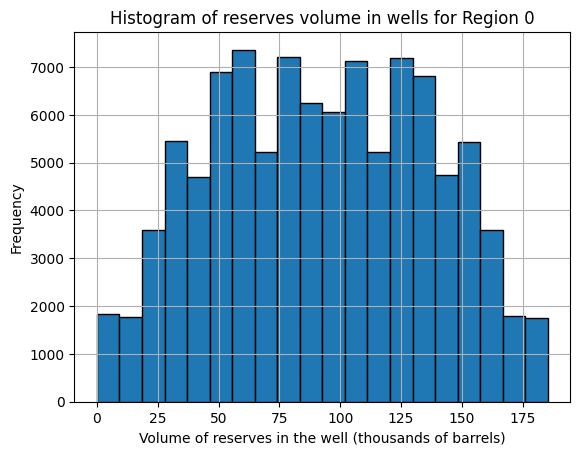

In [8]:
plt.hist(gd0['product'], bins=20, edgecolor='k')
plt.xlabel('Volume of reserves in the well (thousands of barrels)')
plt.ylabel('Frequency')
plt.title('Histogram of reserves volume in wells for Region 0')
plt.grid(True)
plt.show()

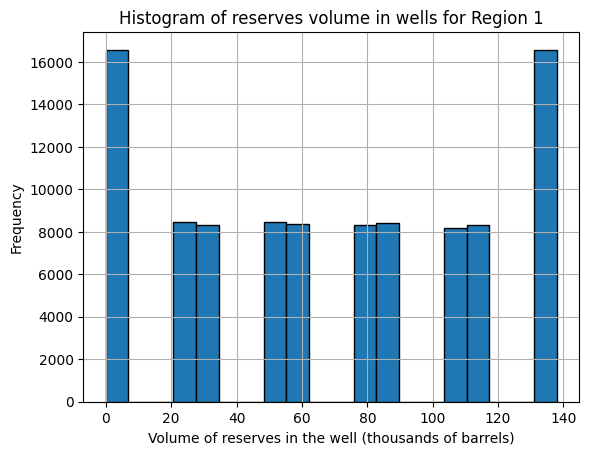

In [9]:
plt.hist(gd1['product'], bins=20, edgecolor='k')
plt.xlabel('Volume of reserves in the well (thousands of barrels)')
plt.ylabel('Frequency')
plt.title('Histogram of reserves volume in wells for Region 1')
plt.grid(True)
plt.show()

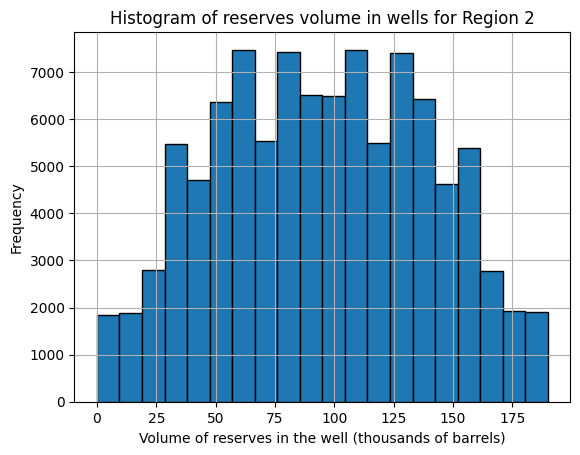

In [10]:
plt.hist(gd2['product'], bins=20, edgecolor='k')
plt.xlabel('Volume of reserves in the well (thousands of barrels)')
plt.ylabel('Frequency')
plt.title('Histogram of reserves volume in wells for Region 2')
plt.grid(True)
plt.show()

Let's check the data for outliers.

/Users/daniyardjumaliev/Jupyter/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


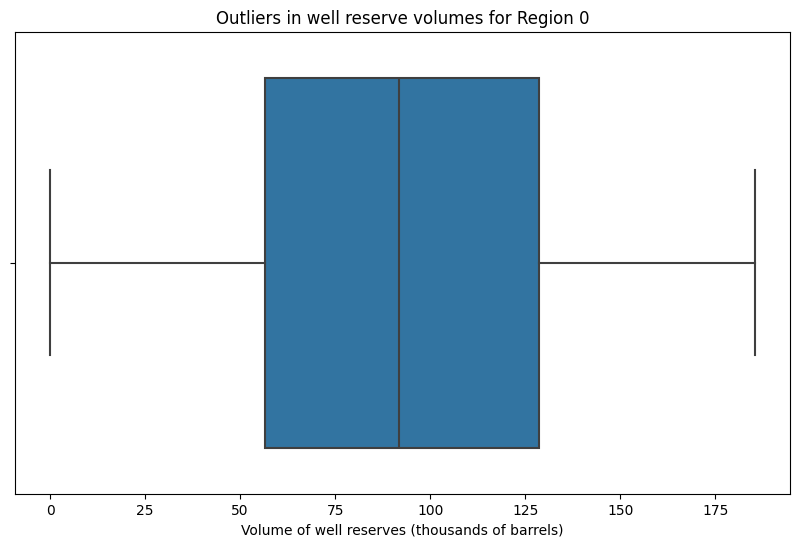

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=gd0['product'])
plt.xlabel('Volume of well reserves (thousands of barrels)')
plt.title('Outliers in well reserve volumes for Region 0')
plt.show()

/Users/daniyardjumaliev/Jupyter/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


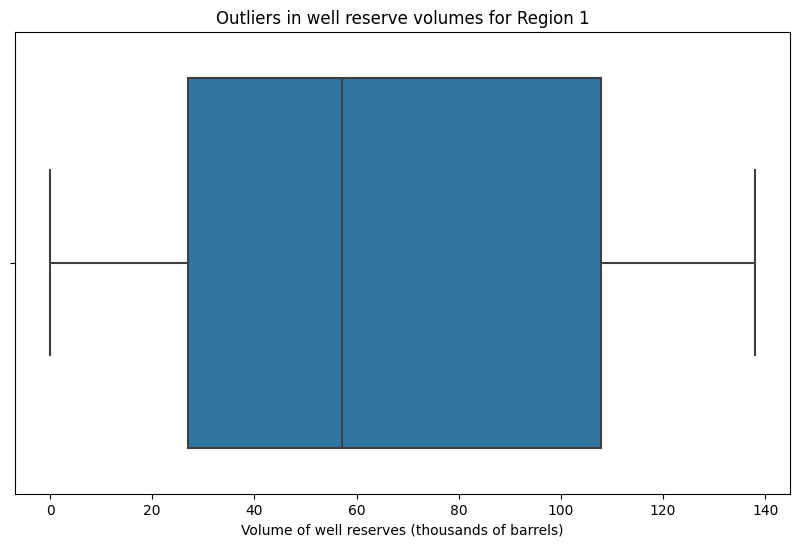

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=gd1['product'])
plt.xlabel('Volume of well reserves (thousands of barrels)')
plt.title('Outliers in well reserve volumes for Region 1')
plt.show()

/Users/daniyardjumaliev/Jupyter/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


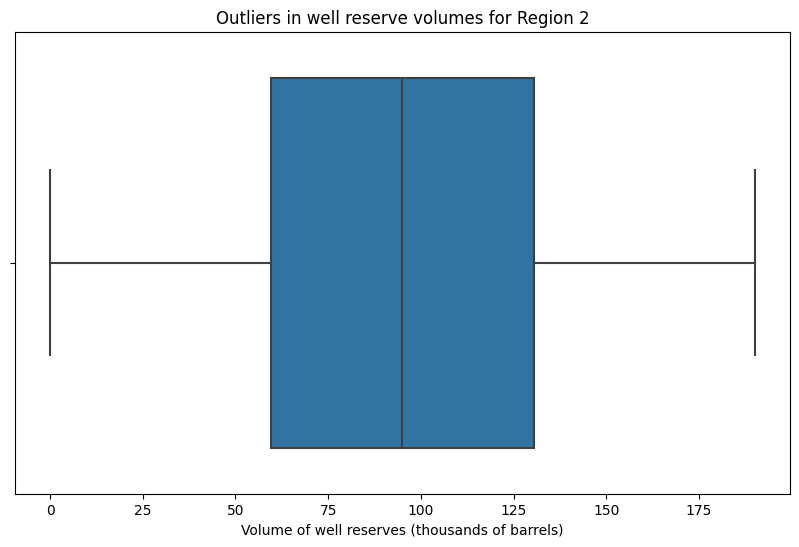

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=gd2['product'])
plt.xlabel('Volume of well reserves (thousands of barrels)')
plt.title('Outliers in well reserve volumes for Region 2')
plt.show()

Let's check the correlation between features.

In [16]:
numeric_columns = gd0.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = gd0[numeric_columns].corr()
display(correlation_matrix)

,f0,f1,f2,product
f0,1.000000,-0.440717,-0.003211,0.143504
f1,-0.440717,1.000000,0.001764,-0.192351
f2,-0.003211,0.001764,1.000000,0.483631
product,0.143504,-0.192351,0.483631,1.000000


In [17]:
numeric_columns = gd1.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = gd1[numeric_columns].corr()
display(correlation_matrix)

,f0,f1,f2,product
f0,1.000000,0.182279,-0.001810,-0.030523
f1,0.182279,1.000000,-0.002594,-0.010154
f2,-0.001810,-0.002594,1.000000,0.999397
product,-0.030523,-0.010154,0.999397,1.000000


In [18]:
numeric_columns = gd2.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = gd2[numeric_columns].corr()
display(correlation_matrix)

,f0,f1,f2,product
f0,1.000000,0.000506,-0.000452,-0.001978
f1,0.000506,1.000000,0.000753,-0.001055
f2,-0.000452,0.000753,1.000000,0.445867
product,-0.001978,-0.001055,0.445867,1.000000


In the first region, there is a strong correlation between the feature f2 and the target variable product. However, the overall data seems to be corrupted and likely contains critical errors. In the other two datasets, in regions zero and two, the highest correlation is observed with the f2 feature, but it is still extremely weak.

_Conclusion_: The data is of sufficient quality, with no missing values detected. Preliminarily, there seem to be no anomalous outliers. However, from the histograms, it is evident that the data in the dataset for region 1 is not normally distributed and has more values at zero and the maximum value. Additionally, based on the graph, it appears that there are missing volumes in the data. The value_counts() function shows that some data is repeated, which is not observed in the tables for regions zero and two. This may be related to the specific characteristics of the wells in this region, but it is more likely that the data in the first dataset contains errors and incorrect values.

## Model Training and Evaluation

Let's write a function that will split the data into training and validation sets for each region, scale the training set, and train a linear regression model. We will also remove the id column since it will not be involved in the training.

In [19]:
def split_and_scale(df):
    features = df.drop(['product', 'id'], axis=1)
    target = df['product']

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    scaler = StandardScaler()
    features_train_scaled = scaler.fit_transform(features_train)
    features_valid_scaled = scaler.transform(features_valid)
    
    print('Training features shape:', features_train.shape)
    print('Validation features shape:', features_valid.shape)
    print()
    print('Training target shape:', target_train.shape)
    print('Validation target shape:', target_valid.shape)
    print()
    return features_train_scaled, features_valid_scaled, target_train, target_valid
    
def model_training(features_train_scaled, features_valid_scaled, target_train, target_valid):
    model = LinearRegression()

    model.fit(features_train_scaled, target_train)
    target_valid_predicted = model.predict(features_valid_scaled)
    mse = mean_squared_error(target_valid, target_valid_predicted)
    
    target_valid_predicted_mean = target_valid_predicted.mean()
    rmse = mse ** 0.5
    
    print(f'Mean predicted reserves: {target_valid_predicted_mean:.1f} thousand barrels')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    
    return target_valid_predicted, rmse

In [20]:
features0_train_scaled, features0_valid_scaled, target0_train, target0_valid = split_and_scale(gd0)
target0_valid_predicted, rmse0 = model_training(features0_train_scaled, features0_valid_scaled, \
                                                     target0_train, target0_valid)

Training features shape: (74992, 3)
Validation features shape: (24998, 3)

Training target shape: (74992,)
Validation target shape: (24998,)

Mean predicted reserves: 92.8 thousand barrels
Root Mean Squared Error (RMSE): 37.853527328872964


In [21]:
features1_train_scaled, features1_valid_scaled, target1_train, target1_valid = split_and_scale(gd1)
target1_valid_predicted, rmse1 = model_training(features1_train_scaled, features1_valid_scaled, \
                                                     target1_train, target1_valid)

Training features shape: (74997, 3)
Validation features shape: (24999, 3)

Training target shape: (74997,)
Validation target shape: (24999,)

Mean predicted reserves: 69.2 thousand barrels
Root Mean Squared Error (RMSE): 0.8920592647717033


In [22]:
features2_train_scaled, features2_valid_scaled, target2_train, target2_valid = split_and_scale(gd2)
target2_valid_predicted, rmse2 = model_training(features2_train_scaled, features2_valid_scaled, \
                                                     target2_train, target2_valid)

Training features shape: (74997, 3)
Validation features shape: (24999, 3)

Training target shape: (74997,)
Validation target shape: (24999,)

Mean predicted reserves: 94.9 thousand barrels
Root Mean Squared Error (RMSE): 40.07585073246016


_Conclusion_: The linear regression model shows insufficiently good results in predicting the target variable - the volume of well reserves. This is likely due to non-linear dependencies in the data.

To reduce RMSE, let's try sequential data engineering.

- Square the zero column.
- Multiply the first and second columns.
- Divide the zero column by the second column.

Square the zero column.

In [23]:
# Squaring the first column for the training set.
features0_train_squared = np.column_stack((features0_train_scaled[:, 0]**2, features0_train_scaled[:, 1], features0_train_scaled[:, 2]))
features1_train_squared = np.column_stack((features1_train_scaled[:, 0]**2, features1_train_scaled[:, 1], features1_train_scaled[:, 2]))
features2_train_squared = np.column_stack((features2_train_scaled[:, 0]**2, features2_train_scaled[:, 1], features2_train_scaled[:, 2]))

# We'll perform similar operations for the validation datasets.
features0_valid_squared = np.column_stack((features0_valid_scaled[:, 0]**2, features0_valid_scaled[:, 1], features0_valid_scaled[:, 2]))
features1_valid_squared = np.column_stack((features1_valid_scaled[:, 0]**2, features1_valid_scaled[:, 1], features1_valid_scaled[:, 2]))
features2_valid_squared = np.column_stack((features2_valid_scaled[:, 0]**2, features2_valid_scaled[:, 1], features2_valid_scaled[:, 2]))

Let's train the model again.

In [24]:
target0_valid_predicted, rmse0 = model_training(features0_train_squared, features0_valid_squared, \
                                                     target0_train, target0_valid)

Mean predicted reserves: 92.8 thousand barrels
Root Mean Squared Error (RMSE): 37.968465870689045


In [25]:
target1_valid_predicted, rmse1 = model_training(features1_train_squared, features1_valid_squared, \
                                                     target1_train, target1_valid)

Mean predicted reserves: 69.2 thousand barrels
Root Mean Squared Error (RMSE): 1.5576664566867275


In [26]:
target2_valid_predicted, rmse2 = model_training(features2_train_squared, features2_valid_squared, \
                                                     target2_train, target2_valid)

Mean predicted reserves: 94.8 thousand barrels
Root Mean Squared Error (RMSE): 39.41808379357142


Managed to reduce RMSE by one unit in the second region.

Let's multiply the first and second columns.

In [27]:
features0_train_mult = np.column_stack((features0_train_scaled[:, 0], features0_train_scaled[:, 1] * features0_train_scaled[:, 2]))
features1_train_mult = np.column_stack((features1_train_scaled[:, 0], features1_train_scaled[:, 1] * features1_train_scaled[:, 2]))
features2_train_mult = np.column_stack((features2_train_scaled[:, 0], features2_train_scaled[:, 1] * features2_train_scaled[:, 2]))

# We'll perform similar operations for the validation datasets.
features0_valid_mult = np.column_stack((features0_valid_scaled[:, 0], features0_valid_scaled[:, 1] * features0_valid_scaled[:, 2]))
features1_valid_mult = np.column_stack((features1_valid_scaled[:, 0], features1_valid_scaled[:, 1] * features1_valid_scaled[:, 2]))
features2_valid_mult = np.column_stack((features2_valid_scaled[:, 0], features2_valid_scaled[:, 1] * features2_valid_scaled[:, 2]))

Train model again.

In [28]:
target0_valid_predicted, rmse0 = model_training(features0_train_mult, features0_valid_mult, \
                                                     target0_train, target0_valid)

Mean predicted reserves: 92.6 thousand barrels
Root Mean Squared Error (RMSE): 43.92467714238949


In [29]:
target1_valid_predicted, rmse1 = model_training(features1_train_mult, features1_valid_mult, \
                                                     target1_train, target1_valid)

Mean predicted reserves: 68.7 thousand barrels
Root Mean Squared Error (RMSE): 45.89869091220373


In [30]:
target2_valid_predicted, rmse2 = model_training(features2_train_mult, features2_valid_mult, \
                                                     target2_train, target2_valid)

Mean predicted reserves: 95.1 thousand barrels
Root Mean Squared Error (RMSE): 44.68385606688519


RMSE increased, and this is definitely not suitable for us.

Divide the zero column by the second column.

In [31]:
# Divide the zero column by the second column, leaving the first column unchanged for the training set.
features0_train_divide = np.column_stack((features0_train_scaled[:, 0], features0_train_scaled[:, 1] / features0_train_scaled[:, 2]))
features1_train_divide = np.column_stack((features1_train_scaled[:, 0], features1_train_scaled[:, 1] / features1_train_scaled[:, 2]))
features2_train_divide = np.column_stack((features2_train_scaled[:, 0], features2_train_scaled[:, 1] / features2_train_scaled[:, 2]))

# We will perform similar operations for the validation datasets.
features0_valid_divide = np.column_stack((features0_valid_scaled[:, 0], features0_valid_scaled[:, 1] / features0_valid_scaled[:, 2]))
features1_valid_divide = np.column_stack((features1_valid_scaled[:, 0], features1_valid_scaled[:, 1] / features1_valid_scaled[:, 2]))
features2_valid_divide = np.column_stack((features2_valid_scaled[:, 0], features2_valid_scaled[:, 1] / features2_valid_scaled[:, 2]))

Train model again.

In [32]:
target0_valid_predicted, rmse0 = model_training(features0_train_divide, features0_valid_divide, \
                                                     target0_train, target0_valid)

Mean predicted reserves: 92.6 thousand barrels
Root Mean Squared Error (RMSE): 43.92469711518099


In [33]:
target1_valid_predicted, rmse1 = model_training(features1_train_divide, features1_valid_divide, \
                                                     target1_train, target1_valid)

Mean predicted reserves: 68.7 thousand barrels
Root Mean Squared Error (RMSE): 45.89837410991702


In [34]:
target2_valid_predicted, rmse2 = model_training(features2_train_divide, features2_valid_divide, \
                                                     target2_train, target2_valid)

Mean predicted reserves: 95.1 thousand barrels
Root Mean Squared Error (RMSE): 44.684146069462805


RMSE increased again compared to the initial findings, so this approach is also not suitable for us.

Now, let's try squaring another column in addition to the zero column.

In [35]:
# Squaring the first column for the training set.
features0_train_squared = np.column_stack((features0_train_scaled[:, 0]**2, features0_train_scaled[:, 1]**2, features0_train_scaled[:, 2]))
features1_train_squared = np.column_stack((features1_train_scaled[:, 0]**2, features1_train_scaled[:, 1]**2, features1_train_scaled[:, 2]))
features2_train_squared = np.column_stack((features2_train_scaled[:, 0]**2, features2_train_scaled[:, 1]**2, features2_train_scaled[:, 2]))

# We'll perform similar operations for the validation datasets.
features0_valid_squared = np.column_stack((features0_valid_scaled[:, 0]**2, features0_valid_scaled[:, 1]**2, features0_valid_scaled[:, 2]))
features1_valid_squared = np.column_stack((features1_valid_scaled[:, 0]**2, features1_valid_scaled[:, 1]**2, features1_valid_scaled[:, 2]))
features2_valid_squared = np.column_stack((features2_valid_scaled[:, 0]**2, features2_valid_scaled[:, 1]**2, features2_valid_scaled[:, 2]))

In [36]:
target0_valid_predicted, rmse0 = model_training(features0_train_squared, features0_valid_squared, \
                                                     target0_train, target0_valid)

Mean predicted reserves: 92.7 thousand barrels
Root Mean Squared Error (RMSE): 38.97829555815206


In [37]:
target1_valid_predicted, rmse1 = model_training(features1_train_squared, features1_valid_squared, \
                                                     target1_train, target1_valid)

Mean predicted reserves: 69.2 thousand barrels
Root Mean Squared Error (RMSE): 1.5949891793050768


In [38]:
target2_valid_predicted, rmse2 = model_training(features2_train_squared, features2_valid_squared, \
                                                     target2_train, target2_valid)

Mean predicted reserves: 94.8 thousand barrels
Root Mean Squared Error (RMSE): 38.80888387660815


After a series of computations, it was found that squaring the second column significantly increases RMSE. It was decided to stick with squaring the zero and first columns because it results in a lower RMSE than the model trained on the original data. In the end, thanks to data engineering, RMSE was reduced:

- Region 0: RMSE remained unchanged.
- Region 1: RMSE remained unchanged.
- Region 2: Reduced from 40.03 to 38.81.

_Conclusion_: Considering that the standard deviation (std) across all three regions is around 44-45, and the obtained RMSE is lower than this value, we will accept the resulting model.

## Profit Calculation Preparation

Let's calculate the minimum volume of raw materials for break-even development of a new well. We will compare this volume with the average reserves in each region.

In [39]:
break_even_volume = BUDGET / (INCOME_PER_PRODUCT_UNIT * BEST_WELLS)
display(f'Volume of raw materials for break-even development of a new well: {break_even_volume:.1f} (thousands of barrels)')
display(f'Average reserves in Region 0: {gd0["product"].mean():.1f} (thousands of barrels)')
display(f'Average reserves in Region 1: {gd1["product"].mean():.1f} (thousands of barrels)')
display(f'Average reserves in Region 2: {gd2["product"].mean():.1f} (thousands of barrels)')

'Volume of raw materials for break-even development of a new well: 111.1 (thousands of barrels)'

'Average reserves in Region 0: 92.5 (thousands of barrels)'

'Average reserves in Region 1: 68.8 (thousands of barrels)'

'Average reserves in Region 2: 95.0 (thousands of barrels)'

Preliminarily, the second and zero regions appear to be the most promising.

_Conclusion_: Based on a preliminary assessment of profitability concerning the region for future development, the second region (average reserves of 95 thousand barrels) and the zero region (average reserves of 92.5 thousand barrels) appear to be the most promising. However, considering that for break-even development of a new well, its volume should be greater than 111 thousand barrels, it becomes evident that development in these regions will involve the risk of losses. To assess the magnitude of these risks, we will conduct an analysis using the bootstrap technique for 1000 samples. If none of the regions shows a risk of losses below 2.5%, it will be recommended to refrain from development in these regions.

## Profit and Risk Calculation

Task conditions:

- During exploration of a region, 500 points are studied, and using machine learning, the top 200 are selected for development.
- The budget for well development in a region is 10 billion rubles.
- At current prices, one barrel of raw material generates revenue of 450 rubles. The revenue from each product unit is 450 thousand rubles since the volume is given in thousands of barrels.
- After assessing risks, only regions with a probability of losses below 2.5% should be considered. Among these, select the region with the highest average profit.

Let's write a function to calculate profit based on selected wells and model predictions.

In [40]:
def calculate_profit(target, predictions):
    data = {'target': target, 'predictions': predictions}
    df = pd.DataFrame(data)
    df.columns = ['target', 'predictions']
    df_sorted = df.sort_values(by='predictions', ascending=False)[:BEST_WELLS]
    profit = (df_sorted['target'].sum() * INCOME_PER_PRODUCT_UNIT) - BUDGET
    return profit

Let's calculate the profit for each region.

In [42]:
profit0 = calculate_profit(target0_valid, target0_valid_predicted)
display(f'Profit for Region 0: {profit0/1e9:.2f} billion rubles')

profit1 = calculate_profit(target1_valid, target1_valid_predicted)
display(f'Profit for Region 0: {profit1/1e9:.2f} billion rubles')

profit2 = calculate_profit(target2_valid, target2_valid_predicted)
display(f'Profit for Region 0: {profit2/1e9:.2f} billion rubles')

'Profit for Region 0: 2.60 billion rubles'

'Profit for Region 0: 2.26 billion rubles'

'Profit for Region 0: 2.36 billion rubles'

Region 0 showed the highest profit with 200 wells predicted by the Linear Regression model: 2.6 billion rubles.

Now let's calculate the risks and profits that can be expected for each region.

In [43]:
def risk(target, predictions):
    target.reset_index(drop=True, inplace=True)
    state = np.random.RandomState(12345)
    profits = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        profit = calculate_profit(target_subsample, predictions_subsample)
        profits.append(profit)
    
    profits = pd.Series(profits)
    lower = profits.quantile(0.025)
    upper = profits.quantile(0.975)
    mean = profits.mean()
    losses_probability = (profits < 0).mean()
    
    display(f'Mean profit: {mean/1e6:.1f} million rubles.')
    display(f'95% confidence interval: {lower/1e6:.0f} – {upper/1e6:.0f} million rubles.')
    display(f'Risk of losses: {losses_probability:.1%}')

In [44]:
#Region 0.
risk0 = risk(target0_valid, target0_valid_predicted)

'Mean profit: 210.6 million rubles.'

'95% confidence interval: -312 – 733 million rubles.'

'Risk of losses: 20.2%'

In [45]:
#Region 1.
risk1 = risk(target1_valid, target1_valid_predicted)

'Mean profit: 457.6 million rubles.'

'95% confidence interval: 64 – 857 million rubles.'

'Risk of losses: 1.3%'

In [46]:
#Region 2.
risk2 = risk(target2_valid, target2_valid_predicted)

'Mean profit: 534.6 million rubles.'

'95% confidence interval: 28 – 1026 million rubles.'

'Risk of losses: 2.1%'

__GENERAL CONCLUSION__: 
- During the data loading stage, it was identified that the data in the first dataset has incorrect values and a non-normal distribution overall. It was hypothesized that this could be related to some geographical features, but it seems more likely to be either a human factor or technical errors.
- The data was divided into two samples - training and validation, 75% and 25% respectively.
- A linear regression model was used for training, as it is the most predictable.
- After training and feature engineering, the RMSE of the model was reduced: Region 0 RMSE remained unchanged, Region 1 RMSE remained unchanged, and Region 2 RMSE decreased from 40.08 to 38.81, which should improve the quality of the model's predicted target features.
- In the calculation of total profit, it was assumed that the most promising region for development is Region 0 - 2.6 billion rubles in net profit.
- When calculating risks using the bootstrap technique, this assumption was refuted - the lowest percentage of the risk of losses is in Region 1 - 1.3%. However, considering that the data in this dataset is corrupted and processed with errors, this value is unlikely to be a valid basis for decision-making. The second-largest risk is in Region 2 - 2.1%, which is below the specified 2.5% threshold.

__Therefore, Region 2 has low chances of incurring losses during development and is recommended for further development as the most promising region.__